# Sequence Model Overlays
Run multiple semantic segmentation sequence models on a sample frame and visualize their overlays side by side.

In [35]:
    # pip install --upgrade torch torchvision onnx

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from io import BytesIO
from PIL import Image
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

In [37]:
# Load a sample from the libero dataset parquet
parquet_path = "~/.cache/huggingface/lerobot/libero/data/chunk-000/file-000.parquet"
df = pd.read_parquet(parquet_path)
print(f"Loaded {len(df)} rows from {parquet_path}")

Loaded 843 rows from ~/.cache/huggingface/lerobot/libero/data/chunk-000/file-000.parquet


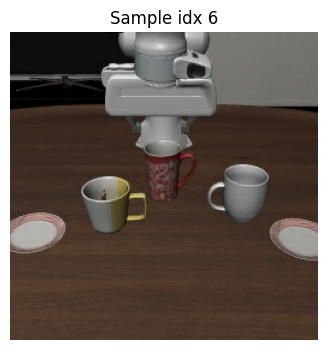

In [38]:
# Pick one frame to reuse across models for consistent comparison
sample_idx = 6
sample_image = Image.open(BytesIO(df['observation.images.image'][sample_idx]['bytes'])).convert("RGB")
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Sample idx {sample_idx}")
plt.show()

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [40]:
# Run a model and return an overlay plus the labels it predicts

def segment_with_overlay(model_id, image, alpha=0.55):
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForSemanticSegmentation.from_pretrained(model_id).to(device).eval()

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    upsampled = torch.nn.functional.interpolate(
        logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    pred = upsampled.argmax(dim=1)[0].cpu().numpy()

    id2label = model.config.id2label
    palette = np.random.randint(0, 255, (len(id2label), 3), dtype=np.uint8)
    seg_rgb = palette[pred]
    overlay = Image.blend(
        image.convert("RGBA"),
        Image.fromarray(seg_rgb).convert("RGBA"),
        alpha=alpha,
    )
    labels_present = sorted({id2label[int(i)] for i in np.unique(pred) if int(i) in id2label})
    return overlay, labels_present

In [41]:
sequence_models = {
    "SegFormer-B0 ADE": "nvidia/segformer-b0-finetuned-ade-512-512",
    "SegFormer-B0 Cityscapes": "nvidia/segformer-b0-finetuned-cityscapes-1024-1024",
    "DeepLabV3 MobileViT Small": "apple/deeplabv3-mobilevit-small",
}


overlays = []
for name, ckpt in sequence_models.items():
    overlay, labels_present = segment_with_overlay(ckpt, sample_image)
    overlays.append((name, overlay, labels_present))
    print(f"{name} -> labels: {labels_present}")

SegFormer-B0 ADE -> labels: ['ashcan', 'basket', 'bottle', 'chair', 'floor', 'glass', 'plate', 'plaything', 'sink', 'stool', 'swivel chair', 'table', 'wall']
SegFormer-B0 Cityscapes -> labels: ['bicycle', 'building', 'car', 'fence', 'motorcycle', 'person', 'pole', 'road', 'sidewalk', 'traffic light', 'traffic sign']
DeepLabV3 MobileViT Small -> labels: ['background']


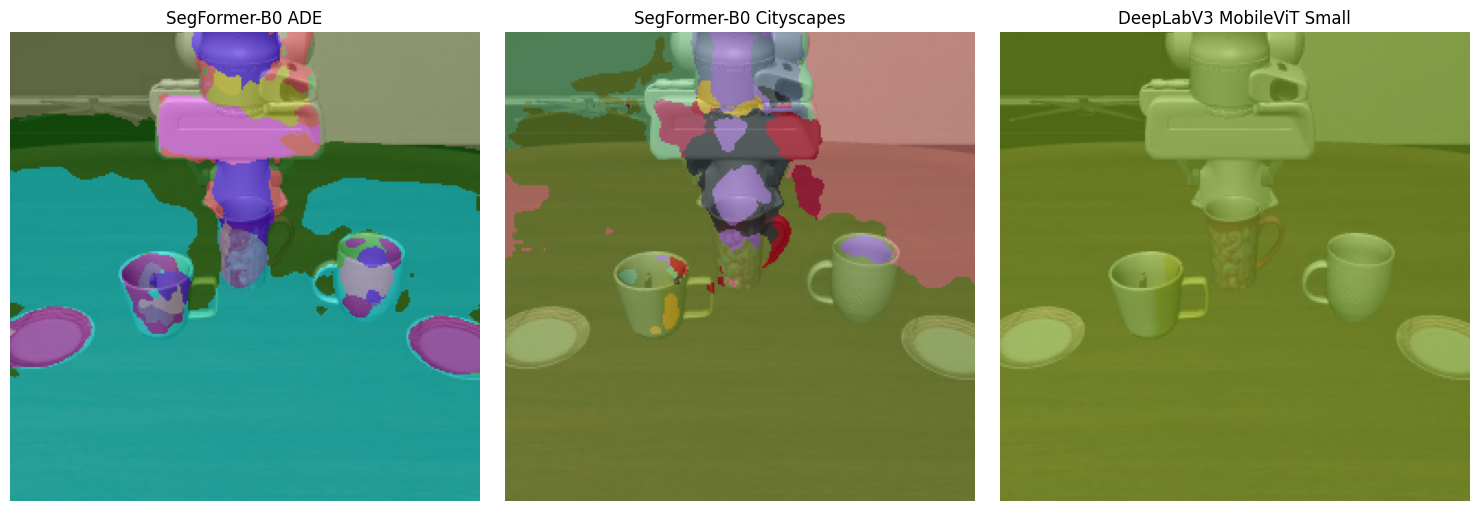

In [42]:
plt.figure(figsize=(5 * len(overlays), 5))
for idx, (name, overlay, labels) in enumerate(overlays, start=1):
    plt.subplot(1, len(overlays), idx)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(name)
plt.tight_layout()
plt.show()

In [43]:
import torch.nn.functional as F

def segment_with_confidence(model_id, image, alpha=0.6):
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForSemanticSegmentation.from_pretrained(model_id).to(device).eval()

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    upsampled = F.interpolate(logits, size=image.size[::-1], mode="bilinear", align_corners=False)
    probs = upsampled.softmax(dim=1)
    pred = probs.argmax(dim=1)[0].cpu().numpy()
    max_conf = probs.max(dim=1).values[0].cpu().numpy()

    id2label = model.config.id2label
    palette = np.random.randint(0, 255, (len(id2label), 3), dtype=np.uint8)
    seg_rgb = palette[pred]
    overlay = Image.blend(image.convert("RGBA"), Image.fromarray(seg_rgb).convert("RGBA"), alpha=alpha)
    labels_present = sorted({id2label[int(i)] for i in np.unique(pred) if int(i) in id2label})

    mean_conf = float(max_conf.mean())
    median_conf = float(np.median(max_conf))
    print(f"{model_id}: mean_max_prob={mean_conf:.3f}, median_max_prob={median_conf:.3f}, labels={labels_present}")
    return overlay, labels_present


In [44]:
conf_results = []
for name, ckpt in sequence_models.items():
    overlay, labels_present = segment_with_confidence(ckpt, sample_image, alpha=0.6)
    conf_results.append((name, labels_present))

nvidia/segformer-b0-finetuned-ade-512-512: mean_max_prob=0.726, median_max_prob=0.815, labels=['ashcan', 'basket', 'bottle', 'chair', 'floor', 'glass', 'plate', 'plaything', 'sink', 'stool', 'swivel chair', 'table', 'wall']
nvidia/segformer-b0-finetuned-cityscapes-1024-1024: mean_max_prob=0.877, median_max_prob=0.990, labels=['bicycle', 'building', 'car', 'fence', 'motorcycle', 'person', 'pole', 'road', 'sidewalk', 'traffic light', 'traffic sign']
apple/deeplabv3-mobilevit-small: mean_max_prob=0.986, median_max_prob=0.999, labels=['background']
